## Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
from skimage import io
import nba_api
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from nba_api.stats.static import teams, players
from nba_api.stats.library.parameters import SeasonAll
from nba_api.stats.endpoints import playergamelog, teamgamelog, teamdashlineups, leaguelineupviz
from nba_api.stats.endpoints.synergyplaytypes import LeagueID
from nba_api.stats.endpoints.shotchartlineupdetail import ConferenceNullable
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.library.parameters import Season
from nba_api.stats.library.parameters import SeasonType

from nba_api.stats.endpoints import commonplayerinfo, shotchartdetail, boxscoreadvancedv3, playbyplay
import pprint
pp = pprint.PrettyPrinter(indent=4)
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import requests
import plotly.graph_objects as go
from plotly.subplots import make_subplots



## Create dictionaries and helper functions

In [3]:
# Select the dictionary for the Pacers, which contains their team ID
player_dict = players.get_players()
nba_teams = teams.get_teams()
player_info = pd.DataFrame.from_dict(player_dict)
team_info = pd.DataFrame.from_dict(nba_teams)
player_dict = player_info[['id','full_name']].set_index('full_name').to_dict()['id']
team_dict = team_info[['id','abbreviation']].set_index('abbreviation').to_dict()['id']
full_name_dict = team_info.set_index('abbreviation').to_dict()['full_name']
full_name_dict['NOH'] = 'New Orleans Pelicans'

## Lineup Ideas: Find best lineups, determine best lineups for individual players

### Create & Save Lineup DataFrame + Helper Function

In [3]:
def reorder_lineup(x):
    return '-'.join(sorted([a for a in x.split('-') if a.strip()]))

url = "https://api.pbpstats.com/get-lineup-player-stats/nba"
lineup_size = 5


In [6]:
seasons = ['2021-22', '2022-23', '2023-24']
season_type = 'Playoffs'
all_lineups_list = []
team = 'MIN'
team_id = team_dict[team]
minimum_mins_played = 2



for season in seasons:
   warriors_lineup_df = teamdashlineups.TeamDashLineups(team_id=team_id,group_quantity=lineup_size,season=season,
                                                        season_type_all_star=season_type)\
            .get_data_frames()[1][['GROUP_SET', 'GROUP_ID', 'GROUP_NAME', 'MIN',
         'FGM', 'FGA', 'FTM', 'FTA', 'OREB', 'DREB', 'AST', 'TOV', 'STL', 'BLK']]
   lineups = list(set(warriors_lineup_df['GROUP_ID']))
   
   for lineup in lineups:
      params = {
         "LineupId": reorder_lineup(lineup), # lineup ids are hyphen separated player ids sorted as strings
         "Season": season,
         "SeasonType": season_type,
         "Minutes":minimum_mins_played
      }
      response = requests.get(url, params=params)
      response_json = response.json()
      lineup_stats = response_json['single_row_table_data']
      if 'FG3M' not in lineup_stats.keys():
         lineup_stats['FG3M'] = 0
      if 'FG2M' not in lineup_stats.keys():
         lineup_stats['FG2M'] = 0
      if 'FG3A' not in lineup_stats.keys():
         lineup_stats['FG3A'] = 0
         lineup_stats['FG3M'] = 0
      if 'FG2A' not in lineup_stats.keys():
         lineup_stats['FG2M'] = 0
         lineup_stats['FG2A'] = 0
      if 'FTA' not in lineup_stats.keys():
         lineup_stats['FTA'] = 0
         lineup_stats['FTM'] = 0
      if 'FTM' not in lineup_stats.keys():
         lineup_stats['FTM'] = 0
      if 'OpponentPoints' not in lineup_stats.keys():
         lineup_stats['OpponentPoints'] = 0
      if 'Points' not in lineup_stats.keys():
         lineup_stats['Points'] = 0
         lineup_stats['TsPct'] = 0.0
      if 'TsPct' not in lineup_stats.keys():
         lineup_stats['TsPct'] = 0.0
      if 'ShortName' not in lineup_stats.keys():
          continue
      elif 'Minutes' not in lineup_stats.keys():
          continue
      elif 'DefPoss' not in lineup_stats.keys():
          continue
      elif 'OffPoss' not in lineup_stats.keys():
          continue
      elif 'Minutes' in lineup_stats.keys() and lineup_stats['Minutes'] < minimum_mins_played:
          continue
      else:
         lineup_df = pd.DataFrame([lineup_stats])[["Name", 'OffPoss', 'DefPoss', "Minutes", 'Points', 'OpponentPoints', 'FG2M', 'FG2A', 'FG3M', 'FG3A', 'TsPct','FTA']]
         lineup_df = lineup_df.rename(columns={'Name':'Lineup','Points':'Team Points','FG2M': 'Team FG2M', 'FG2A':'Team FG2A', 'FG3M':'Team FG3M', 'FG3A':'Team FG3A', 'TsPct':'Team TsPct','FTA':'Team FTA'})
         lineup_df['Season'] = season
         lineup_df['Team'] = team
         player_stats = response_json['multi_row_table_data']
         for player_stat in player_stats:
            if not set(['Points','TsPct']).issubset(player_stat.keys()):
                  player_stat['Points'] = 0
                  player_stat['TsPct'] = 0.0
            if 'FG3A' not in player_stat.keys():
               player_stat['FG3A'] = 0
               player_stat['FG3M'] = 0
            if 'FG2A' not in player_stat.keys():
               player_stat['FG2M'] = 0
               player_stat['FG2A'] = 0
            if 'FTA' not in player_stat.keys():
               player_stat['FTA'] = 0
            if 'OpponentPoints' not in player_stat.keys():
                  player_stat['OpponentPoints'] = 0
            if 'Minutes' not in player_stat.keys():
               player_stat['Minutes'] = 0
            if 'OffPoss' not in player_stat.keys():
                  player_stat['OffPoss'] = 0
            if 'DefPoss' not in player_stat.keys():
                  player_stat['DefPoss'] = 0
            player_df = pd.DataFrame([player_stat])[['Name', 'EntityId', 'Minutes', 'OffPoss', 'DefPoss', 'Points', 'OpponentPoints', 'TsPct','FG2A','FG3A','FTA']]
            all_lineups_list.append(player_df.merge(lineup_df,on=['Minutes','OffPoss','DefPoss','OpponentPoints']))

In [7]:
all_lineups_df = pd.concat(all_lineups_list).reset_index(drop=True)
all_lineups_df['PtsPer75'] = all_lineups_df['Points'] * 75 / all_lineups_df['OffPoss']
all_lineups_df['FGA'] = all_lineups_df['FG2A'] + all_lineups_df['FG3A']
all_lineups_df['Team FGA'] = all_lineups_df['Team FG2A'] + all_lineups_df['Team FG3A']
all_lineups_df.to_csv(f'{team} Lineup Data ({season_type}).csv')

### Initialize Players + Team

In [12]:
team = 'MIN'
key_player = 'Anthony Edwards'
star_player = 'Karl-Anthony Towns'
role_player = 'Michael Porter Jr.'
all_lineups_df_reg_season = pd.read_csv(f'{team} Lineup Data (Regular Season).csv')
all_lineups_df_reg_season['Season Type'] = 'Regular Season'
all_lineups_df_playoffs = pd.read_csv(f'{team} Lineup Data (Playoffs).csv')
all_lineups_df_playoffs['Season Type'] = 'Playoffs'



### Track Player Production in Same Lineup across multiple years

In [5]:
all_lineups_df_comb = all_lineups_df_reg_season[all_lineups_df_reg_season['Name']==key_player][['Lineup','OffPoss','Minutes','Points','FGA','FTA']].groupby('Lineup').sum().reset_index().sort_values(by='Minutes')
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)
all_lineups_df_comb[role_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if role_player in x else 0)
no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[role_player] == 0)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
two_legends_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 1)&(all_lineups_df_comb[role_player] == 0)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
two_shooters_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[role_player] == 1)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
everyone_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 1)&(all_lineups_df_comb[role_player] == 1)][['Lineup','OffPoss','Minutes','Points','FGA','FTA']]
ns_mins = np.sum(no_stars_df)['Minutes']
jk_mins = np.sum(two_shooters_df)['Minutes']
js_mins = np.sum(two_legends_df['Minutes'])
e_mins = np.sum(everyone_df['Minutes'])

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [6]:

print(f'Points Per 75 without {role_player} or {star_player} ({ns_mins} Minutes Played):')
print(round(np.sum(no_stars_df)['Points'] * 75/ np.sum(no_stars_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(no_stars_df)['Points'] * 100 / (2 * (np.sum(no_stars_df)['FGA'] + 0.44 * np.sum(no_stars_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with just {role_player} ({jk_mins} Minutes Played):')
print(round(np.sum(two_shooters_df)['Points'] * 75/ np.sum(two_shooters_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(two_shooters_df)['Points'] * 100 / (2 * (np.sum(two_shooters_df)['FGA'] + 0.44 * np.sum(two_shooters_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with just {star_player} ({js_mins} Minutes Played):')
print(round(np.sum(two_legends_df)['Points'] * 75/ np.sum(two_legends_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(two_legends_df)['Points'] * 100 / (2 * (np.sum(two_legends_df)['FGA'] + 0.44 * np.sum(two_legends_df)['FTA'])),2))
print('\n')
print(f'Points Per 75 with everyone ({e_mins} Minutes Played):')
print(round(np.sum(everyone_df)['Points'] * 75/ np.sum(everyone_df)['OffPoss'],2))
print("TS%:")
print(round(np.sum(everyone_df)['Points'] * 100 / (2 * (np.sum(everyone_df)['FGA'] + 0.44 * np.sum(everyone_df)['FTA'])), 2))
print('\n')

Points Per 75 without Michael Porter Jr. or Jamal Murray (4219 Minutes Played):
29.11
TS%:
63.8


Points Per 75 with just Michael Porter Jr. (2595 Minutes Played):
27.81
TS%:
64.17


Points Per 75 with just Jamal Murray (4605 Minutes Played):
24.42
TS%:
61.19


Points Per 75 with everyone (3087 Minutes Played):
25.5
TS%:
69.31




C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-

### Player Production Lineups for the Same Year

In [13]:
all_lineups_df_comb = all_lineups_df_playoffs[['Lineup','OffPoss','DefPoss','Minutes','Points','Team Points','OpponentPoints','FGA','FTA','Season','Name']]
all_lineups_df_comb[key_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if key_player in x else 0)
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)

no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[key_player] == 0)][['OffPoss','Minutes','Points','FGA','FTA','Season']].groupby('Season').sum().reset_index()
no_stars_df['PtsPer75'] = round(no_stars_df['Points'] * 75/ no_stars_df['OffPoss'],2)
no_stars_df['TS%'] = round(no_stars_df['Points'] * 100 / (2 * no_stars_df['FGA'] + 0.44 * no_stars_df['FTA']),2)
no_stars_df['Designation'] = 'No Key Players'

one_star_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 1)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name']].groupby(['Season','Name']).sum().reset_index()
one_star_df = one_star_df[one_star_df['Name'].isin([star_player,key_player])]
one_star_df['PtsPer75'] = round(one_star_df['Points'] * 75/ one_star_df['OffPoss'],2)
one_star_df['TS%'] = round(one_star_df['Points'] * 100 / (2 * one_star_df['FGA'] + 0.44 * one_star_df['FTA']),2)
one_star_df['Designation'] = 'One Star Player ' +  '(' + one_star_df['Name'].apply(lambda x: x.split()[-1]) + ')'

two_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 2)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name']].groupby(['Season','Name']).sum().reset_index()
two_stars_df = two_stars_df[two_stars_df['Name'].isin([star_player,key_player])]
two_stars_df['PtsPer75'] = round(two_stars_df['Points'] * 75/ two_stars_df['OffPoss'],2)
two_stars_df['TS%'] = round(two_stars_df['Points'] * 100 / (2 * two_stars_df['FGA'] + 0.44 * two_stars_df['FTA']),2)
two_stars_df['Designation'] = 'Both Stars ' + '(' + two_stars_df['Name'].apply(lambda x: x.split()[-1]) + ')'


comb_df = pd.concat([no_stars_df,one_star_df,two_stars_df]).reset_index(drop=True)

fig2 = px.line(comb_df, x = 'Season', y = 'PtsPer75',color = 'Designation',title=f'Production of {key_player} in Lineups',
        hover_data={'TS%':True, 'Minutes':True,'Designation':False,'Season':False})
fig2.show()


C:\Users\ynakadi\AppData\Local\Temp\ipykernel_19748\2086704192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lineups_df_comb[key_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if key_player in x else 0)
C:\Users\ynakadi\AppData\Local\Temp\ipykernel_19748\2086704192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)
C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundati

### Reg Season vs Playoffs

In [14]:
all_lineups_df_comb = pd.concat([all_lineups_df_reg_season,all_lineups_df_playoffs])
all_lineups_df_comb = all_lineups_df_comb[['Lineup','OffPoss','DefPoss','Minutes','Points','Team Points','OpponentPoints','FGA','FTA','Season','Name','Season Type']]
all_lineups_df_comb[key_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if key_player in x else 0)
all_lineups_df_comb[star_player] = all_lineups_df_comb['Lineup'].apply(lambda x: 1 if star_player in x else 0)

no_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player] == 0)&(all_lineups_df_comb[key_player] == 0)][['OffPoss','Minutes','Points','FGA','FTA','Season','Season Type']].groupby(['Season','Season Type']).sum().reset_index()
no_stars_df['PtsPer75'] = round(no_stars_df['Points'] * 75/ no_stars_df['OffPoss'],2)
no_stars_df['TS%'] = round(no_stars_df['Points'] * 100 / (2 * no_stars_df['FGA'] + 0.44 * no_stars_df['FTA']),2)
no_stars_df['Designation'] = 'No Key Players'
no_stars_df_reg, no_stars_df_post = no_stars_df[no_stars_df['Season Type'] == 'Regular Season'], no_stars_df[no_stars_df['Season Type'] == 'Playoffs']
no_stars_df_post = no_stars_df_post.rename(columns={'TS%':"Playoffs TS%",'PtsPer75':'Playoffs PtsPer75'})
no_stars_df_comb = no_stars_df_reg.merge(no_stars_df_post[['Season','Playoffs TS%','Playoffs PtsPer75']],on='Season')
no_stars_df_comb['TS% Playoffs Difference'] = round(no_stars_df_comb['Playoffs TS%'] - no_stars_df_comb['TS%'],2)
no_stars_df_comb['PtsPer75 Playoffs Difference'] = (no_stars_df_comb['Playoffs PtsPer75'] - no_stars_df_comb['PtsPer75']).round(2)


one_star_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 1)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name','Season Type']].groupby(['Season','Name','Season Type']).sum().reset_index()
one_star_df = one_star_df[one_star_df['Name'].isin([star_player,key_player])]
one_star_df['PtsPer75'] = round(one_star_df['Points'] * 75/ one_star_df['OffPoss'],2)
one_star_df['TS%'] = round(one_star_df['Points'] * 100 / (2 * one_star_df['FGA'] + 0.44 * one_star_df['FTA']),2)
one_star_df['Designation'] = 'One Star Player ' +  '(' + one_star_df['Name'].apply(lambda x: x.split()[-1]) + ')'
one_star_df_reg, one_star_df_post = one_star_df[one_star_df['Season Type'] == 'Regular Season'], one_star_df[one_star_df['Season Type'] == 'Playoffs']
one_star_df_post = one_star_df_post.rename(columns={'TS%':"Playoffs TS%",'PtsPer75':'Playoffs PtsPer75'})
one_star_df_comb = one_star_df_reg.merge(one_star_df_post[['Season','Name','Playoffs TS%','Playoffs PtsPer75']],on=['Season','Name'])
one_star_df_comb['TS% Playoffs Difference'] = round(one_star_df_comb['Playoffs TS%'] - one_star_df_comb['TS%'],2)
one_star_df_comb['PtsPer75 Playoffs Difference'] = round(one_star_df_comb['Playoffs PtsPer75'] - one_star_df_comb['PtsPer75'],2)

two_stars_df = all_lineups_df_comb[(all_lineups_df_comb[star_player]  + all_lineups_df_comb[key_player] == 2)][['OffPoss','Minutes','Points','FGA','FTA','Season','Name','Season Type']].groupby(['Season','Name','Season Type']).sum().reset_index()
two_stars_df = two_stars_df[two_stars_df['Name'].isin([star_player,key_player])]
two_stars_df['PtsPer75'] = round(two_stars_df['Points'] * 75/ two_stars_df['OffPoss'],2)
two_stars_df['TS%'] = round(two_stars_df['Points'] * 100 / (2 * two_stars_df['FGA'] + 0.44 * two_stars_df['FTA']),2)
two_stars_df['Designation'] = 'Both Stars ' + '(' + two_stars_df['Name'].apply(lambda x: x.split()[-1]) + ')'
two_stars_df_reg, two_stars_df_post = two_stars_df[two_stars_df['Season Type'] == 'Regular Season'], two_stars_df[two_stars_df['Season Type'] == 'Playoffs']
two_stars_df_post = two_stars_df_post.rename(columns={'TS%':"Playoffs TS%",'PtsPer75':'Playoffs PtsPer75'})
two_stars_df_comb = two_stars_df_reg.merge(two_stars_df_post[['Season','Name','Playoffs TS%','Playoffs PtsPer75']],on=['Season','Name'])
two_stars_df_comb['TS% Playoffs Difference'] = round(two_stars_df_comb['Playoffs TS%'] - two_stars_df_comb['TS%'],2)
two_stars_df_comb['PtsPer75 Playoffs Difference'] = round(two_stars_df_comb['Playoffs PtsPer75'] - two_stars_df_comb['PtsPer75'],2)



comb_df = pd.concat([no_stars_df_comb,one_star_df_comb,two_stars_df_comb]).reset_index(drop=True)

fig2 = px.line(comb_df, x = 'Season', y = 'PtsPer75',color = 'Designation',title=f'Production of {key_player} in Lineups',
        hover_data={'TS%':True, 'Minutes':True,'Designation':False,'Season':True,'TS% Playoffs Difference':True,'PtsPer75 Playoffs Difference':True})
fig2.show()

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



NBA Podcast (Wharton Moneyball) Notes 
- Seth Stephens-Davidowitz: Who Makes the NBA?, Everybody Lies
- Idea: normalize for height
    - Each inch doubles your chances of joining the nba (7 footers have a 1/7 chance, general population)
- Idea: MJ is 9th best height-adjusted player
    - Muggsy Boges is #1 all time, Chris Paul is #1 among active players
- Idea: negative relation between height and athletic abilities/certain skills
    - Intuition: you don't have to be as good
- Idea: FT% as proxy for clutch shooting (clutch is <= 5 mins remaining in game)
    - Other shots tend to be low probability
    - Typically players' FT% decreased by 1%
    - Influenced primarily by height
- Is clutchness multidimensional or singular
- Coaching:
    - NBA Coaches make the biggest difference
    - Best ideas are in blogs
        - How good player was before playing for the coach compared to now
        - Also adjust for age
- Fixed effect model on how often player passes ball when driving to basket
- PLayers have incentive to solely score: great coaches get players to be more passive 

## Game by Game Data (Basic Team Stats, ORTG, think of other ideas)

### Create Dataframe (if necessary)

In [90]:
dfs = []
def get_opponent(stri):
  if '@' in stri:
    return stri.replace(' ','').split('@')[1]
  else:
    return stri.replace(' ','').split('.')[1]

def get_location(stri):
  if '@' in stri:
    return 0
  else:
    return 1
start_year = 2012
end_year = 2024
for season in [str(x) + '-' + str(x + 1)[2:] for x in range(start_year,end_year)]:
    print(season)
    east_games = leaguegamefinder.LeagueGameFinder(
                              league_id_nullable=LeagueID.nba,
                              vs_conference_nullable=ConferenceNullable.east,
                              season_nullable=season)

    west_games = leaguegamefinder.LeagueGameFinder(
                              league_id_nullable=LeagueID.nba,
                              vs_conference_nullable=ConferenceNullable.west,
                              season_nullable=season
                              )

    # Eastern Conference
    east_games_dict = east_games.get_normalized_dict()
    east_games = east_games_dict['LeagueGameFinderResults']
    east_games_df = pd.DataFrame.from_dict(east_games)
    east_games_df['Opponent Conference'] = 'East'
    
    # Western Conference
    west_games_dict = west_games.get_normalized_dict()
    west_games = west_games_dict['LeagueGameFinderResults']
    west_games_df = pd.DataFrame.from_dict(west_games)
    west_games_df['Opponent Conference'] = 'West'
    
    # Combine them
    comb_df = pd.concat([east_games_df, west_games_df]).reset_index(drop=True)
    
    # Extract Relevant Data
    comb_df['GAME_DATE'] = pd.to_datetime(comb_df['GAME_DATE'])
    comb_df['GAME_TYPE'] = comb_df['GAME_ID'].apply(lambda x: x[2])
    comb_df['SEASON'] = season
    #Filter out preseason, all-star games
    comb_df = comb_df[(comb_df['TEAM_ABBREVIATION'].isin(full_name_dict.keys())) & ((comb_df["GAME_TYPE"] != '1') & (comb_df['GAME_TYPE'] != '3'))]
    comb_df['PTS Allowed'] = comb_df['PTS'] - comb_df['PLUS_MINUS']
    comb_df['Opponent'] = comb_df['MATCHUP'].apply(lambda x: get_opponent(x))
    comb_df['At Home'] = comb_df['MATCHUP'].apply(lambda x: get_location(x))
    dfs.append(comb_df)
game_by_game_df = pd.concat(dfs)
game_by_game_df['Win'] = game_by_game_df['WL'].apply(lambda x: 1 if x == 'W' else 0)

2012-13
2013-14
2014-15
2015-16
2016-17
2017-18
2018-19
2019-20
2020-21
2021-22
2022-23
2023-24


In [91]:
key_cols = ['TEAM_ABBREVIATION', 'GAME_ID','GAME_DATE', 'PTS', 'PTS Allowed', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'Win']
game_by_game_opps_df = game_by_game_df[key_cols]
game_by_game_opps_df = game_by_game_opps_df.add_prefix("Opponent ")
combined_df = game_by_game_df.merge(game_by_game_opps_df,right_on=['Opponent TEAM_ABBREVIATION','Opponent GAME_ID', 'Opponent GAME_DATE'],
                           left_on=['Opponent','GAME_ID','GAME_DATE'])
combined_df = combined_df.drop(['Opponent TEAM_ABBREVIATION', 'Opponent GAME_ID',
       'Opponent GAME_DATE','PLUS_MINUS','TEAM_ID','TEAM_NAME','WL','MIN'],axis=1)

In [92]:
combined_df.to_csv('game_by_game.csv', index=False)

### Import DataFrame

In [12]:
game_by_game_df = pd.read_csv('game_by_game.csv',converters={'GAME_ID': str})

In [94]:
game_by_game_df.columns

Index(['SEASON_ID', 'TEAM_ABBREVIATION', 'GAME_ID', 'GAME_DATE', 'MATCHUP',
       'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'Opponent Conference', 'GAME_TYPE', 'SEASON', 'PTS Allowed', 'Opponent',
       'At Home', 'Win', 'Opponent PTS', 'Opponent PTS Allowed',
       'Opponent FGM', 'Opponent FGA', 'Opponent FG_PCT', 'Opponent FG3M',
       'Opponent FG3A', 'Opponent FG3_PCT', 'Opponent FTM', 'Opponent FTA',
       'Opponent FT_PCT', 'Opponent OREB', 'Opponent DREB', 'Opponent AST',
       'Opponent STL', 'Opponent BLK', 'Opponent TOV', 'Opponent PF',
       'Opponent Win'],
      dtype='object')

### Add Features (maybe remove)

In [14]:
off_rating_df = game_by_game_df[['SEASON','GAME_DATE','GAME_ID','GAME_TYPE','TEAM_ABBREVIATION','PTS','TOV','FGA','FGM','FTA','OREB','DREB']]

team1_df = off_rating_df.sort_values(by='GAME_ID').reset_index(drop=True).iloc[::2]#[['GAME_ID','TEAM_ABBREVIATION','PTS','TOV','FGA','FGM','FTA','OREB','DREB']]
team2_df = off_rating_df.sort_values(by='GAME_ID').reset_index(drop=True).iloc[1::2]

comb1_df = team1_df.merge(team2_df.rename(columns={'TEAM_ABBREVIATION':'OPP TEAM_ABBREVIATION','PTS':'OPP PTS','TOV':'OPP TOV','FGA':'OPP FGA','FGM':'OPP FGM','FTA':'OPP FTA','OREB':'OPP OREB','DREB':'OPP DREB'}), on = 'GAME_ID')
comb2_df = team2_df.merge(team1_df.rename(columns={'TEAM_ABBREVIATION':'OPP TEAM_ABBREVIATION','PTS':'OPP PTS','TOV':'OPP TOV','FGA':'OPP FGA','FGM':'OPP FGM','FTA':'OPP FTA','OREB':'OPP OREB','DREB':'OPP DREB'}), on = 'GAME_ID')
new_stats_df = pd.concat([comb1_df,comb2_df]).sort_values(by='GAME_ID')
new_stats_df = new_stats_df.drop(['SEASON_y','GAME_DATE_y','GAME_TYPE_y'],axis=1)
new_stats_df = new_stats_df.rename(columns = {'SEASON_x' : 'SEASON', 'GAME_DATE_x' : 'GAME_DATE','GAME_TYPE_x':'GAME_TYPE'})

In [15]:
# Pt 1: (Tm FGA + 0.4 * Tm FTA - 1.07 * (Tm ORB / (Tm ORB + Opp DRB)) * (Tm FGA - Tm FG) + Tm TOV)
# Pt 2: (Opp FGA + 0.4 * Opp FTA - 1.07 * (Opp ORB / (Opp ORB + Tm DRB)) * (Opp FGA - Opp FG) + Opp TOV)
def calc_possessions(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return (pt1 + pt2) * 0.5

def calc_offrating(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return round(row['PTS'] * 200 / (pt1 + pt2),1)

def calc_defrating(row):
    pt1 = (row['FGA'] + 0.4 * row['FTA'] - 1.07 * (row['OREB'] / (row['OREB'] + row['OPP DREB'])) * (row['FGA'] - row['FGM']) + row['TOV'])
    pt2 = (row['OPP FGA'] + 0.4 * row['OPP FTA'] - 1.07 * (row['OPP OREB'] / (row['OPP OREB'] + row['DREB'])) * (row['OPP FGA'] - row['OPP FGM']) + row['OPP TOV'])
    return row['OPP PTS'] * 200 / (pt1 + pt2)

new_stats_df['NUM POSSESSIONS'] = new_stats_df.apply(lambda row: calc_possessions(row), axis = 1)
new_stats_df['OFF RATING'] = 100 * new_stats_df['PTS'] / new_stats_df['NUM POSSESSIONS']
new_stats_df['DEF RATING'] = 100 * new_stats_df['OPP PTS'] / new_stats_df['NUM POSSESSIONS']
new_stats_df['NET RATING'] = new_stats_df['OFF RATING'] - new_stats_df['DEF RATING']

In [17]:
new_stats_df[(new_stats_df['GAME_TYPE']==4)&(new_stats_df['GAME_DATE']<'2025-01-01')&(new_stats_df['TEAM_ABBREVIATION']=='MIN')]

,SEASON,GAME_DATE,GAME_ID,GAME_TYPE,TEAM_ABBREVIATION,PTS,TOV,FGA,FGM,FTA,...,OPP TOV,OPP FGA,OPP FGM,OPP FTA,OPP OREB,OPP DREB,NUM POSSESSIONS,OFF RATING,DEF RATING,NET RATING
13371,2017-18,2018-04-15,0041700141,4,MIN,101,13,80,35,28,...,11,83,39,23,8,29,92.799375,108.836940,112.069720,-3.232780
13372,2017-18,2018-04-18,0041700142,4,MIN,82,16,80,31,21,...,9,96,35,21,12,42,97.153460,84.402553,104.988541,-20.585988
13373,2017-18,2018-04-21,0041700143,4,MIN,121,7,90,45,22,...,10,81,37,25,7,32,94.465500,128.089091,111.151690,16.937400
13374,2017-18,2018-04-23,0041700144,4,MIN,100,16,84,39,23,...,6,92,40,26,10,36,97.770471,102.280371,121.713641,-19.433270
13375,2017-18,2018-04-25,0041700145,4,MIN,104,8,79,40,20,...,4,88,45,19,8,32,89.991625,115.566310,135.568171,-20.001861
13704,2021-22,2022-04-16,0042100151,4,MIN,130,18,90,45,27,...,12,86,39,43,8,27,105.352782,123.394939,111.055445,12.339494
13705,2021-22,2022-04-19,0042100152,4,MIN,96,19,76,30,28,...,9,92,44,32,14,34,100.219074,95.790149,123.728942,-27.938793
13706,2021-22,2022-04-21,0042100153,4,MIN,95,16,85,33,23,...,18,83,35,31,13,35,98.690879,96.260162,105.379546,-9.119384
13707,2021-22,2022-04-23,0042100154,4,MIN,119,15,74,35,40,...,17,86,42,25,6,33,101.635882,117.084633,116.100729,0.983904
13708,2021-22,2022-04-26,0042100155,4,MIN,109,22,83,37,24,...,16,94,39,39,18,35,106.690203,102.164957,104.039543,-1.874586


In [18]:
new_stats_reg_df = new_stats_df[new_stats_df['GAME_TYPE'] == 2][['SEASON','TEAM_ABBREVIATION','PTS','OPP PTS','NUM POSSESSIONS']]
new_stats_reg_df['TEAM'] = new_stats_reg_df['TEAM_ABBREVIATION'] + ' ' + new_stats_reg_df['SEASON']
season_stats_df = new_stats_reg_df[['TEAM','PTS','OPP PTS','NUM POSSESSIONS']].groupby('TEAM').sum()
season_stats_df['OFF RATING'] = round(100 * season_stats_df['PTS'] / season_stats_df['NUM POSSESSIONS'],1)
season_stats_df['DEF RATING'] = round(100 * season_stats_df['OPP PTS'] / season_stats_df['NUM POSSESSIONS'],1)
season_stats_df['NET RATING'] = season_stats_df['OFF RATING'] - season_stats_df['DEF RATING']
season_stats_df.sort_values(by='OFF RATING').tail(20)

,PTS,OPP PTS,NUM POSSESSIONS,OFF RATING,DEF RATING,NET RATING
TEAM,,,,,,
DEN 2022-23,9495,9222,8024.116694,118.3,114.9,3.4
POR 2020-21,8360,8231,7068.430953,118.3,116.4,1.9
LAC 2020-21,8209,7764,6934.288319,118.4,112.0,6.4
UTA 2020-21,8382,7716,7081.034552,118.4,109.0,9.4
GSW 2023-24,8063,7941,6794.982815,118.7,116.9,1.8
ATL 2023-24,8095,8232,6822.229274,118.7,120.7,-2.0
NOP 2023-24,7886,7528,6637.716895,118.8,113.4,5.4
PHX 2023-24,8067,7893,6791.678227,118.8,116.2,2.6
BOS 2022-23,9671,9136,8141.908019,118.8,112.2,6.6


In [19]:
new_stats_reg_df = new_stats_df[new_stats_df['GAME_TYPE'] == 4][['SEASON','TEAM_ABBREVIATION','OFF RATING','DEF RATING','NET RATING']]
new_stats_reg_df['TEAM'] = new_stats_reg_df['TEAM_ABBREVIATION'] + ' ' + new_stats_reg_df['SEASON']
season_stats_df = new_stats_reg_df[['TEAM','OFF RATING','DEF RATING','NET RATING']].groupby('TEAM').mean().round(1)

season_stats_df.sort_values(by = 'OFF RATING',ascending=False).head(20)

,OFF RATING,DEF RATING,NET RATING
TEAM,,,
UTA 2019-20,123.4,119.2,4.2
UTA 2020-21,122.6,123.9,-1.3
POR 2020-21,122.2,123.2,-1.0
LAC 2020-21,121.6,117.2,4.4
CLE 2016-17,120.9,112.5,8.4
DEN 2022-23,120.3,111.5,8.8
GSW 2016-17,119.3,106.0,13.4
NOP 2021-22,118.5,120.1,-1.6
BOS 2022-23,118.2,114.6,3.6


In [20]:
# Regular Season Games
reg_games = game_by_game_df[game_by_game_df['GAME_TYPE'] == 2]
game_by_game_df['Team'] = game_by_game_df['TEAM_ABBREVIATION'] + ' ' + game_by_game_df['SEASON']

wins = game_by_game_df[['TEAM_ABBREVIATION','Win','SEASON','GAME_TYPE']].groupby(by=['TEAM_ABBREVIATION','SEASON','GAME_TYPE']).count().reset_index()

# Playoff Games
playoff_teams = game_by_game_df[game_by_game_df['GAME_TYPE'] >= 4]['Team']
post_games = game_by_game_df[game_by_game_df['GAME_TYPE'] >= 4]

graph_df = post_games[['TEAM_ABBREVIATION','PLUS_MINUS','SEASON','Win']].groupby(by=['TEAM_ABBREVIATION','SEASON']).agg(Wins=('Win', np.sum),Plus_Minus =('PLUS_MINUS', np.mean)).reset_index()
graph_df['Team'] = graph_df['TEAM_ABBREVIATION'] + ' ' + graph_df['SEASON']
graph_df = graph_df.sort_values(by='Wins',ascending=True)

fig = px.scatter(graph_df[graph_df['Team'].isin(playoff_teams)], x = 'Wins', y = 'Plus_Minus', color = 'TEAM_ABBREVIATION', text="Team")
fig.update_traces(textposition='top center')
fig.show()

graph2_df = post_games[['TEAM_ABBREVIATION','PTS','SEASON','PTS Allowed']].groupby(by=['TEAM_ABBREVIATION','SEASON']).mean().reset_index()
graph2_df['Team'] = graph2_df['TEAM_ABBREVIATION'] + ' ' + graph2_df['SEASON']
fig2 = px.scatter(graph2_df[graph2_df['Team'].isin(playoff_teams)], x = 'PTS', y = 'PTS Allowed', color = 'TEAM_ABBREVIATION', text="Team")
fig2.update_traces(textposition='top center')
fig2['layout']['yaxis']['autorange'] = "reversed"
fig2.show()


C:\Users\ynakadi\AppData\Local\Temp\ipykernel_23284\2916166130.py:11: FutureWarning: The provided callable <function sum at 0x000001DF9E8AC5E0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  graph_df = post_games[['TEAM_ABBREVIATION','PLUS_MINUS','SEASON','Win']].groupby(by=['TEAM_ABBREVIATION','SEASON']).agg(Wins=('Win', np.sum),Plus_Minus =('PLUS_MINUS', np.mean)).reset_index()
C:\Users\ynakadi\AppData\Local\Temp\ipykernel_23284\2916166130.py:11: FutureWarning: The provided callable <function mean at 0x000001DF9E8AD510> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  graph_df = post_games[['TEAM_ABBREVIATION','PLUS_MINUS','SEASON','Win']].groupby(by=['TEAM_ABBREVIATION','SEASON']).agg(Wins=('Win', np.sum),Plus_Minus =('PLUS_MINUS', np.me

C:\Users\ynakadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\plotly\express\_core.py:1992: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



## Shot Chart Detail Ideas

In [4]:


bucks_df = game_by_game_df[(game_by_game_df['TEAM_ABBREVIATION'] == 'MIL')&(game_by_game_df['SEASON']=='2022-23')]

#player_details = [player for player in player_dict if player['full_name'] == 'Giannis Antetokounmpo'][0]


player_num = player_dict['Giannis Antetokounmpo']
print(player_num)

player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_num)
player_stats = player_info.player_headline_stats.get_dict()
print(player_stats)


pd.options.display.max_seq_items = 100
shot_chart = shotchartdetail.ShotChartDetail(
player_id = 0,
season_nullable='2021-22',
season_type_all_star='Regular Season',
team_id=team_dict['MIL'],
context_measure_simple='FGA',)


shot_df = shot_chart.shot_chart_detail.get_data_frame()
shot_df['Opponent'] = shot_df['HTM'].apply(lambda x: x if x != 'MIL' else '') + shot_df['VTM'].apply(lambda x: x if x != 'MIL' else '')
shot_df['Shot'] = shot_df['SHOT_ZONE_AREA'] + ' ' + shot_df['SHOT_ZONE_BASIC']
# Columns: 'GAME_ID', 'GAME_EVENT_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_NAME', 'PERIOD', 
# 'MINUTES_REMAINING', 'SECONDS_REMAINING', 'EVENT_TYPE', 'ACTION_TYPE', 'SHOT_TYPE', 'SHOT_ZONE_BASIC', 
# 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE', 'SHOT_DISTANCE' 'LOC_X', 'LOC_Y', 'SHOT_ATTEMPTED_FLAG', 'SHOT_MADE_FLAG', 
# 'GAME_DATE', 'HTM', 'VTM'
print(set(shot_df['Opponent']))
shot_df[['PLAYER_ID','Opponent','Shot','SHOT_MADE_FLAG']]\
    .groupby(['PLAYER_ID','Opponent','Shot']).agg({'SHOT_MADE_FLAG':['count','mean']})
# # Get specific player shot chart
# player_made_df = shot_df[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['PLAYER_ID']==player_num)]
# player_missed_df = shot_df[(shot_df['SHOT_MADE_FLAG']==0) & (shot_df['PLAYER_ID']==player_num)]

# # Get rest of team shot chart
# rest_of_team_made_df = shot_df[(shot_df['SHOT_MADE_FLAG']==1) & (shot_df['PLAYER_ID']!=player_num)]
# rest_of_team_missed_df = shot_df[(shot_df['SHOT_MADE_FLAG']==0) & (shot_df['PLAYER_ID']!=player_num)]
# giannis_df = shot_df[(shot_df['PLAYER_ID']==player_num)]

bucks_games = pd.concat([boxscoreadvancedv3.BoxScoreAdvancedV3(game_id = game).get_data_frames()[0] for game in set(bucks_df['GAME_ID'])])
# #bucks_games_pbp = pd.concat([playbyplay.PlayByPlay(game).get_data_frames()[0] for game in set(bucks_df['GAME_ID'])])
# giannis_games = bucks_games[bucks_games['NICKNAME'] == 'Giannis']

203507
{'headers': ['PLAYER_ID', 'PLAYER_NAME', 'TimeFrame', 'PTS', 'AST', 'REB', 'PIE'], 'data': [[203507, 'Giannis Antetokounmpo', '2023-24', 30.4, 6.5, 11.5, 0.197]]}
{'TOR', 'CLE', 'UTA', 'SAS', 'HOU', 'MIA', 'PHI', 'BKN', 'SAC', 'POR', 'MIN', 'DEN', 'PHX', 'LAL', 'NOP', 'ORL', 'OKC', 'LAC', 'GSW', 'DET', 'CHI', 'IND', 'CHA', 'ATL', 'BOS', 'NYK', 'MEM', 'WAS', 'DAL'}


KeyboardInterrupt: 

In [24]:
# bucks_games[['gameId','personId','teamTricode','comment','minutes','offensiveRating', 'defensiveRating', 'netRating',
#               'offensiveReboundPercentage', 'pace','possessions']]

x = game_by_game_df[game_by_game_df['TEAM_ABBREVIATION']=='MIL'].sort_values(by='GAME_DATE')[["TEAM_ID",
'TEAM_ABBREVIATION','GAME_ID','GAME_DATE','PTS','TOV','PF','PTS Allowed','At Home',
'FGA','FG_PCT','FG3A', 'FG3_PCT', 'FTA', 'FT_PCT', 'OREB', 'DREB','AST', 'STL', 'BLK','Opponent','Win']].head(2)

KeyError: "['TEAM_ID'] not in index"

In [35]:
rows = []
mil2012_df = game_by_game_df[(game_by_game_df['SEASON']=='2016-17')].sort_values(by='GAME_DATE')[[
'TEAM_ABBREVIATION','GAME_ID','GAME_DATE','PTS','TOV','PF','At Home',
'FGA','FGM','FG3A', 'FG3M', 'FTA', 'FTM', 'OREB', 'DREB','AST', 'STL', 'BLK','Opponent',
'Opponent PTS', 'Opponent FGM', 'Opponent FGA',
       'Opponent FG_PCT', 'Opponent FG3M', 'Opponent FG3A', 'Opponent FG3_PCT',
       'Opponent FTM', 'Opponent FTA', 'Opponent FT_PCT', 'Opponent OREB',
       'Opponent DREB', 'Opponent AST', 'Opponent STL', 'Opponent BLK',
       'Opponent TOV', 'Opponent PF','SEASON','Opponent Win','Win']]
count = 0
for a, row in mil2012_df.iterrows():
    count += 1
    if count % 10 == 0:
        print(count)
    boxscore_df = boxscoreadvancedv3.BoxScoreAdvancedV3(game_id = row.GAME_ID).get_data_frames()[1]
    boxscore_df = boxscore_df[['gameId', 'teamId', 'teamTricode','offensiveRating','defensiveRating','possessions','assistToTurnover','offensiveReboundPercentage', 'defensiveReboundPercentage']]
    boxscore_team = boxscore_df[boxscore_df['teamTricode'] == row.TEAM_ABBREVIATION]
    boxscore_opponent = boxscore_df[boxscore_df['teamTricode'] != row.TEAM_ABBREVIATION]
    boxscore_opponent = boxscore_opponent.add_prefix("Opponent ")
    row = pd.DataFrame(row).transpose()
    row = row.merge(boxscore_team,left_on=['GAME_ID','TEAM_ABBREVIATION'],right_on=['gameId','teamTricode'])
    row = row.merge(boxscore_opponent,left_on=['GAME_ID'],right_on=['Opponent gameId'])
    rows.append(row)

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [36]:
full_df = pd.concat(rows)
full_df = full_df.drop(['gameId', 'teamId', 'teamTricode','Opponent gameId', 'Opponent teamId'],axis = 1)
full_df.to_csv('2016_17alldata.csv')


In [ ]:
full_df = pd.read_csv('2016_17alldata.csv')
full_df = full_df.drop(['Unnamed: 0'],axis = 1)
full_df['Postseason Game'] = full_df['GAME_ID'].apply(lambda x: 1 if str(x)[0] == '4' else 0)
full_df = full_df[full_df['Postseason Game'] == 0]

window_size = 8

In [ ]:
test_df = full_df.sort_values(by=['TEAM_ABBREVIATION','GAME_DATE']).reset_index(drop=True)

test_df['Cum Wins'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).apply(lambda x:
    x.Win.cumsum().shift(1)).reset_index(drop=True)

test_df = test_df.fillna(0)

test_df['Games so Far'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).cumcount()

test_df['Win Percentage'] = test_df['Cum Wins'] / test_df['Games so Far']


test_df['L10 Win Percentage'] = test_df[['TEAM_ABBREVIATION','SEASON','Win']]\
    .groupby(['TEAM_ABBREVIATION','SEASON'])['Win'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) / window_size

test_df['L10 BLKS'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['BLK'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 ASTS'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['AST'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 PPG'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['PTS'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
test_df['L10 Opponent PPG'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent PTS'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 TOV'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['TOV'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
test_df['L10 TOV Forced'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent TOV'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 PF'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['PF'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
test_df['L10 PF Drawn'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent PF'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 OREB'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['OREB'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
test_df['L10 Opponent OREB'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent OREB'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 DREB'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['DREB'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
test_df['L10 Opponent DREB'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent DREB'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 FGA Avg'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FGA'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
test_df['L10 Opponent FGA Avg'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent FGA'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 FG3A Avg'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FG3A'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 
test_df['L10 Opponent FG3A Avg'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent FG3A'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 FTA Avg'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FTA'].shift(1).rolling(window=window_size).mean().reset_index(drop=True) 

test_df['L10 FGA'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FGA'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 
test_df['L10 Opponent FGA'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent FGA'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 

test_df['L10 FG3A'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FG3A'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 
test_df['L10 Opponent FG3A'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent FG3A'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 

test_df['L10 FTA'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FTA'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 

test_df['L10 FGM'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FGM'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 
test_df['L10 Opponent FGM'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent FGM'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 

test_df['L10 FG3M'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FG3M'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 
test_df['L10 Opponent FG3M'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['Opponent FG3M'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 

test_df['L10 FTM'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON'])['FTM'].shift(1).rolling(window=window_size).sum().reset_index(drop=True) 

test_df['L10 FG_PCT'] = test_df['L10 FGM'] / test_df['L10 FGA']
test_df['L10 FG3_PCT'] = test_df['L10 FG3M'] / test_df['L10 FG3A']
test_df['L10 Opponent FG_PCT'] = test_df['L10 Opponent FGM'] / test_df['L10 Opponent FGA']
test_df['L10 Opponent FG3_PCT'] = test_df['L10 Opponent FG3M'] / test_df['L10 Opponent FG3A']

test_df['L10 FT_PCT'] = test_df['L10 FTM'] / test_df['L10 FTA']
test_df = test_df.drop(['L10 FGM','L10 FGA','L10 FTM','L10 FTA','L10 FG3M',
'L10 FG3A', 'L10 Opponent FGM','L10 Opponent FGA','L10 Opponent FG3M',
'L10 Opponent FG3A', 'TOV','PTS', 'PF','FGA', 'FGM', 'FG3A', 'FG3M',
'FTA', 'FTM', 'OREB', 'DREB','AST', 'STL', 'BLK','Opponent PTS', 
'Opponent FGM','Opponent FGA', 'Opponent FG_PCT', 'Opponent FG3M', 'Opponent FG3A',
'Opponent FG3_PCT', 'Opponent FTM', 'Opponent FTA', 'Opponent FT_PCT',
'Opponent OREB', 'Opponent DREB', 'Opponent AST', 'Opponent STL',
'Opponent BLK', 'Opponent TOV', 'Opponent PF'],axis=1)

C:\Users\ynakadi\AppData\Local\Temp\ipykernel_28172\1194518001.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_df['Cum Wins'] = test_df.groupby(['TEAM_ABBREVIATION','SEASON']).apply(lambda x:


In [31]:
test_df

,TEAM_ABBREVIATION,GAME_ID,GAME_DATE,At Home,Opponent,SEASON,Opponent Win,Win,offensiveRating,defensiveRating,...,L10 FGA Avg,L10 Opponent FGA Avg,L10 FG3A Avg,L10 Opponent FG3A Avg,L10 FTA Avg,L10 FG_PCT,L10 FG3_PCT,L10 Opponent FG_PCT,L10 Opponent FG3_PCT,L10 FT_PCT
0,ATL,21500001,2015-10-27,1,DET,2015-16,1,0,96.9,107.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ATL,21500019,2015-10-29,0,NYK,2015-16,0,1,109.8,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ATL,21500026,2015-10-30,1,CHA,2015-16,0,1,99.0,94.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ATL,21500039,2015-11-01,0,CHA,2015-16,0,1,98.9,95.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ATL,21500055,2015-11-03,0,MIA,2015-16,0,1,100.0,94.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,WAS,21501167,2016-04-06,1,BKN,2015-16,0,1,121.0,105.1,...,88.750,86.750,25.875,26.750,22.125,0.470423,0.386473,0.476945,0.369159,0.677966
2456,WAS,21501182,2016-04-08,0,DET,2015-16,1,0,104.2,116.7,...,89.250,88.500,26.250,24.750,22.125,0.470588,0.357143,0.468927,0.368687,0.706215
2457,WAS,21501194,2016-04-10,1,CHA,2015-16,0,1,110.8,96.1,...,88.500,87.625,24.875,23.500,23.500,0.473164,0.346734,0.460770,0.372340,0.696809
2458,WAS,21501206,2016-04-11,0,BKN,2015-16,0,1,116.5,107.8,...,86.000,85.750,23.875,24.375,24.125,0.475291,0.340314,0.437318,0.379487,0.699482


## PBP Data (Lead Volatility Idea)

### Create PBP Dataset

In [83]:
game_season_dict = game_by_game_df[['SEASON','GAME_ID']].set_index('GAME_ID').to_dict()['SEASON']
game_season_dict
# games = sorted(list(set(game_by_game_df['GAME_ID'])))
main_df = []
num_so_far = 12552
shuffle = 1500
count = 0
for game in [x for x in list(set(game_by_game_df['GAME_ID'])) if x not in games]:
    df = pd.DataFrame()
    pbp_df = playbyplay.PlayByPlay(game).get_data_frames()[0]
    count += 1
    if count % 100  == 0:
        print(count)
    pbp_df = pbp_df[(pbp_df['SCOREMARGIN'].notnull())]
    pbp_df['SCOREMARGIN'] = pbp_df['SCOREMARGIN'].replace("TIE","0").apply(lambda x: int(x))
    main_df.append(pbp_df)


# First 12552

100
200


In [84]:
# First runthrough
#pbp_df = pd.concat(main_df)
pbp_df = pd.read_csv('pbp_df.csv', converters={'GAME_ID':str})
pbp_df = pd.concat([pbp_df,pd.concat(main_df)])#[['Season','Blown Leads']].groupby('Season').agg({'Blown Leads':['sum','count']})
pbp_df.to_csv('pbp_df.csv', index=False)

In [67]:
pbp_df = pbp_df.drop_duplicates()
pbp_df.to_csv('pbp_df.csv', index=False)

In [85]:
len(set(pbp_df['GAME_ID']))

14142

### Analyze

In [72]:
pbp_df = pd.read_csv('pbp_df.csv', converters={'GAME_ID':str})

In [73]:
big_lead = 15
small_deficit = 0
#pbp_df = pbp_df.sort_values(by=['GAME_ID','EVENTNUM']).reset_index(drop=True)
pbp_df['new_game'] = pbp_df['GAME_ID'] != pbp_df.shift(1)['GAME_ID']
pbp_df['state'] = pbp_df.apply(lambda x:'ng' if x.new_game else \
                           ('sl' if np.abs(x.SCOREMARGIN) <= small_deficit else \
                            ('bl' if np.abs(x.SCOREMARGIN) >= big_lead else None)),axis=1)
blown_leads_df = pbp_df[['SCOREMARGIN','state','GAME_ID','new_game']].dropna().reset_index(drop=True)
blown_leads_df['check'] = blown_leads_df['state'] + blown_leads_df.shift(1)['state'] 

In [74]:
blown_games = list(blown_leads_df[blown_leads_df['check']=='slbl']['GAME_ID'])
blown_leads_df = blown_leads_df[blown_leads_df['check']=='slbl']
blown_leads_df['Season'] = blown_leads_df['GAME_ID'].apply(lambda x: '20' + str(x[3:5]) + '-' + str(int(x[3:5])+1))
blown_leads_df['Season Type'] = blown_leads_df['GAME_ID'].apply(lambda x: 'Regular Season' if x[2] == '2' else 'Playoffs')
blown_leads_df[['Season','Season Type','GAME_ID']].groupby(['Season','Season Type']).count()

GAME_ID
Season  Season Type            
2013-14 Playoffs             12
        Regular Season      163
2014-15 Playoffs             11
        Regular Season      148
2015-16 Playoffs             10
        Regular Season      165
2016-17 Playoffs             11
        Regular Season      182
2017-18 Playoffs              9
        Regular Season      195
2018-19 Playoffs             14
        Regular Season      208
2019-20 Playoffs             13
        Regular Season      177
2020-21 Playoffs             17
        Regular Season      152
2021-22 Playoffs             12
        Regular Season      188
2022-23 Playoffs             15
        Regular Season      230
2023-24 Playoffs              8
        Regular Season      219

## Data Visualization Ideas

In [ ]:
image_df = pd.read_csv("NBAIMAGES.csv")
image_df["Team"] = image_df['Team'].apply(lambda x: full_name_dict[x])
#image_df

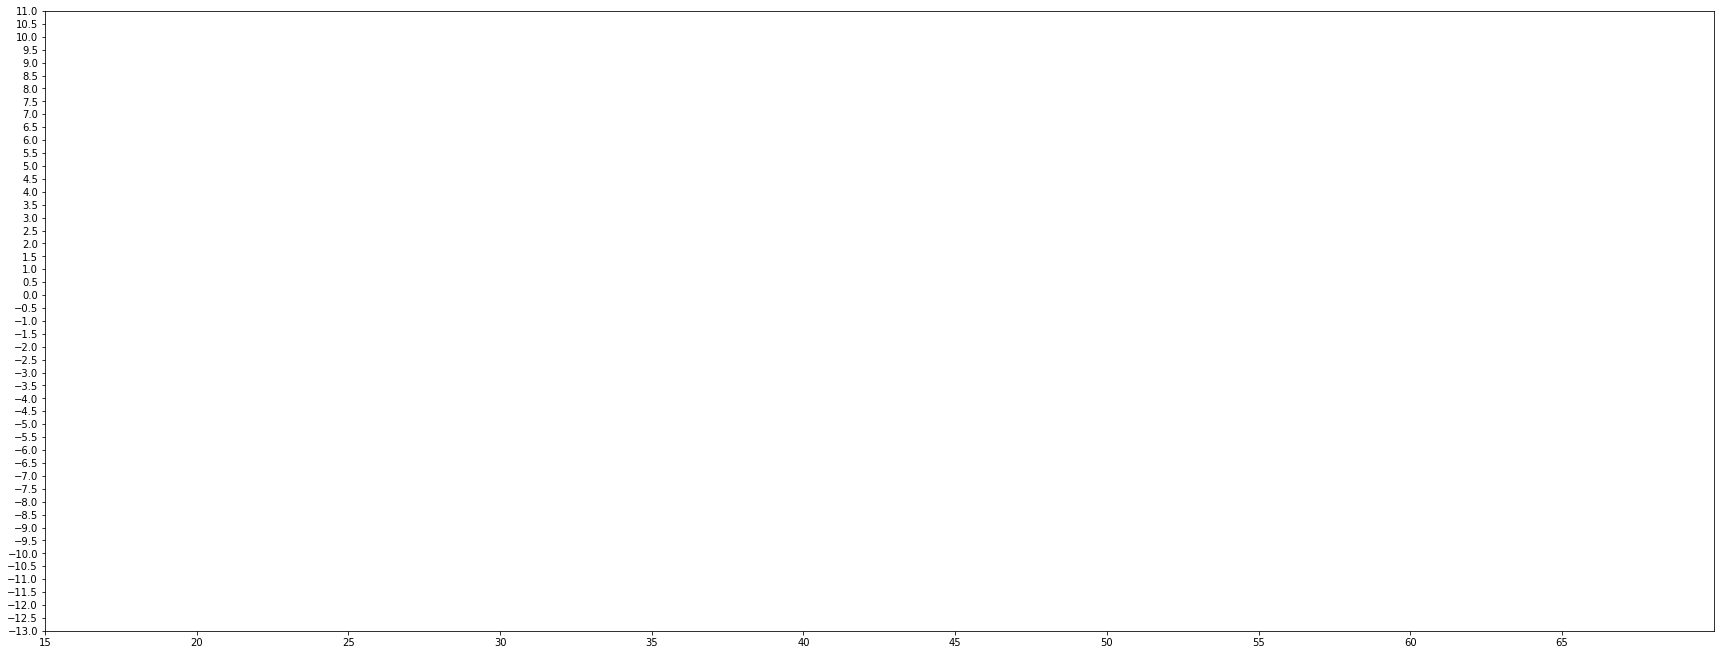

In [ ]:
scale = 0.8
x_shift = -.7 * scale
y_shift = -.8 * scale
image_shift = 500.0
zoom_shift = 0.06 * scale
length = 30.00 * scale
width = 11.50 * scale

plt.rcParams["figure.figsize"] = [length, width]
plt.rcParams["figure.autolayout"] = True

def getImage(path,alpha):
    img = io.imread(path)
    img = resize(img, (img.shape[0] * image_shift / img.shape[0],img.shape[1] *  image_shift / img.shape[1], 4),
                       anti_aliasing=True)
    return OffsetImage(img, zoom=zoom_shift,alpha=alpha)


graph2_df = graph_df.merge(image_df,  on= "Team").sample(frac=0.1)
x = [i for i in list(graph2_df['Wins'])]
y = [i for i in list(graph2_df['Plus_Minus'])]
z = [i for i in list(graph2_df["SEASON"])]
paths = list(graph2_df['Image Link'])

# Create Graph and Put Images in Place

fig, ax = plt.subplots()
for x0, y0, z0, path in zip(x, y, z, paths):
    alpha_val = 0.9
    ab = AnnotationBbox(getImage(path,alpha_val), (x0, y0), frameon=False)
    ax.annotate(z0, xy=(x0+x_shift,y0+y_shift))
    ax.add_artist(ab)

# X and Y Ticks on graph
plt.xticks(np.arange(0, 70, step=5))
plt.yticks(np.arange(-15, 15, step=0.5))
plt.xlim([15, 70])
plt.ylim([-13, 11])
fig = px.scatter(graph2_df, x = 'Wins', y = 'Plus_Minus', color = 'TEAM_ABBREVIATION', hover_name = "Team", text="SEASON")
fig.show()
# plt.show()